# These are some quick exercises on MNIST. The code was written for the sake of understanding the algorithms better and is optimized for simplicity, not for efficiency or speed. 

- K-Means finds k (in this case k=20) clusters that best represent the data space of the digits. The centers of the clusters are then shown.
- PCA reduces the dimentionality of the data. Our images are 28x28=784 length vectors. But can we represent them with, say 100 numbers instead? The principal components, as well as lower dimentional representations of images are shown. 
- EM is an algorithm for coming up with a generative model. In this case we model each number as a vector of 784 Bernoulli trials. We analyze each class to come up with n (in this case n=3) distributions that are likely to generate the numbers in that class. We also estimate probabilities, or prevalences of each of those distributions. To classify a digit, we calculate the probability that the given digit comes from each of the pre-measured distributions and take argmax. Below, I only estimated 3 distributions per class to save runtime, however I believe much better accuracy can be achieved if I allowed for more. 

## K-MEANS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from IPython.display import clear_output


In [2]:
d = sio.loadmat('mnist')
X = d["trainX"]
y = d["trainY"].squeeze()
X = X[list(np.random.choice(len(X), replace=False, size=250))].tolist() #sampling 250 numbers. 
#Note I converted to list bc I implemented kmeans as lists. in retrospect having everything be arrays would make things easier
#But shouldn't matter much

In [3]:
def get_sq_dist(x1, x2): #returns squared distance between two vectors.
    n = len(x1)
    sq_sum = 0
    for i in range(n):
        sq_sum += (x2[i]-x1[i])**2
    return sq_sum

In [4]:
def init_means_pp(data, k): #kmeans++ means initialization
    means = []
    ind1 = np.random.randint(len(data), size=1)[0] #first one chosen by random
    means.append(data[ind1])
    for i in range(k-1): 
        distances = [] #distances contains a list of distance sums from every other point to our current means
        for j in range(len(data)): #going over every other point
            new_dist = 0 #calculating distance from one point to all the means
            if data[j] in means: #skipping the point that is already a mean (in rare cases the alg choses the same point twice)
                distances.append(0)
                continue;
            for m in range(len(means)): #iterating over means to get new_dist
                new_dist += get_sq_dist(data[j], means[m]) 
            distances.append(new_dist)
        new_ind = distances.index(max(distances)) #next mean index is chosen to be the point with max distance to current means
        means.append(data[new_ind])
    return means

In [5]:
def init_means_forgy(data, k): #forgy means initialization
    inds = np.random.choice(len(X), size=k, replace=False)
    means = np.asarray(X)[inds].tolist()
    return means
    

In [6]:
def assign_to_clusters(data, means): #assigns all pointsin data to one of the k clusters 
    clust = [] #clust[i] = 0,1...k-1 based on which cluster data[i] belongs to
    for i in range(len(data)):
        distances = [] #distance from a given point to all the means
        for m in range(len(means)):
            distances.append(get_sq_dist(data[i], means[m])) #chosing the minimum distance
        clust.append(distances.index(min(distances)))
    return clust

In [7]:
def get_new_means(data, clust, k): #calculates means given the clusters
    means = []
    for k_num in range(k): 
        filt = [x==k_num for x in clust] #filtering data based on clusters
        means.append(list(np.asarray(data)[filt].mean(axis=0))) #getting mean in a cluster
    return means
    

In [8]:
def get_loss(data, clust, means, k): # returns the squared sum of all points from their cluster means
    loss = 0
    for k_num in range(k):
        filt = [x==k_num for x in clust]
        data_in_k = np.asarray(data)[filt]
        for i in range(len(data_in_k)):
            loss+=get_sq_dist(data_in_k[i], means[k_num])
    return loss

In [9]:
def kmeans(data, k, init_function): #runs kmeans once (until convergence) and returns means and loss
    if init_function=='kmeans++':
        means = init_means_pp(data, k)
    else:
        means = init_means_forgy(data, k)
    clusters = assign_to_clusters(data, means)
    new_means = get_new_means(data, clusters, k)
    while(new_means!=means): #converged
        means=new_means
        clusters = assign_to_clusters(data, means)
        new_means = get_new_means(data, clusters, k)
    loss = get_loss(data, clusters, new_means, k)
    return new_means, loss

In [10]:
#Checking out the best and worst iterations out of a few. 
#I'm doing this to see if the clusters are robust to random initializations.
def best_worst_loss_kmeans(X, k, iterations, init_f): #runs kmeans iterations times and returns means and loss corresponding to the best and worst solution 
    means, loss = kmeans(X, k, init_f)
    best_means = means
    best_loss = loss
    worst_means = means
    worst_loss = loss
    for i in range(iterations-1):
        print(i) #i'm just printing this cuz its annoying to wait for 20 mins not knowing how much running is left
        new_means, new_loss = kmeans(X, k, init_f)
        if new_loss<best_loss:
            best_means = new_means
            best_loss = new_loss
        if new_loss>worst_loss:
            worst_loss = new_loss
            worst_means = new_means
        clear_output() #clearing the printed i
    return best_means, worst_means

In [11]:
best, worst = best_worst_loss_kmeans(X, 20, 20, 'forgy')

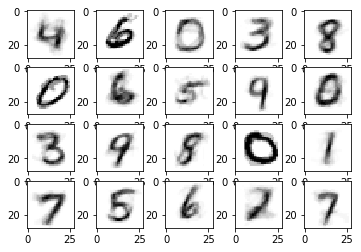

In [12]:
#best iteration means
for i in range(1,21):
    ax = plt.subplot(4,5,i)
    x = np.asarray(best[i-1])
    ax.imshow(x.reshape((28, 28)), cmap="Greys")
plt.show()

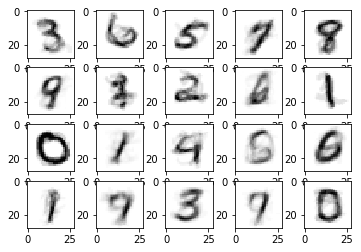

In [13]:
#worst iteration means
for i in range(1,21):
    ax = plt.subplot(4,5,i)
    x = np.asarray(worst[i-1])
    ax.imshow(x.reshape((28, 28)), cmap="Greys")
plt.show()

In [15]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## PCA

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy 
from scipy.sparse.linalg import svds, eigs
from sklearn.cluster import KMeans
from scipy.stats import mode
from matplotlib.pyplot import figure

In [17]:
data=np.float64(np.load('MNIST.npy'))
labels=np.float32(np.load('MNIST_labels.npy'))

In [18]:
data/=255
ls = list(range(0, 70000))
train_mask = random.sample(ls, int(70000*0.6))
train_data = data[train_mask]
train_labels = labels[train_mask]
therest = list(set(ls)-set(train_mask))
test_mask = random.sample(therest, int(70000*0.2))
test_data = data[test_mask]
test_labels = labels[test_mask]
dev_mask = list(set(therest)-set(test_mask))
dev_data = data[dev_mask]
dev_labels = labels[dev_mask]

In [19]:
# centering the data
centered_train_data = copy.deepcopy(train_data)
train_mean = train_data.mean(axis=0)
for i in range(centered_train_data.shape[0]):
    centered_train_data[i]-=train_mean

In [20]:
%%time
# SVD
U,S,Vt = svds(np.matrix.transpose(centered_train_data), k=500)

Wall time: 29.8 s


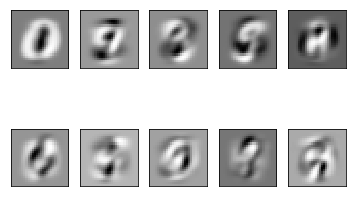

In [21]:
#First 10 principal components
U = np.flip(U, axis=1) #for some reason scipy orders in reverse
S = np.flip(S, axis=0) #same for this

for i in range(1,11):
    ax = plt.subplot(2,5,i)
    x = U[:,i-1]
    ax.imshow(x.reshape((28, 28)), cmap="Greys")
    plt.xticks([])
    plt.yticks([])
plt.show()

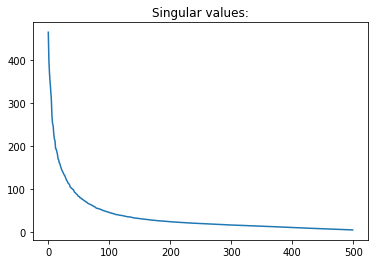

In [22]:
plt.title("Singular values:")
plt.plot(S)

In [23]:
def transform_and_show(data_ind, m, ax):
    datapoint = centered_train_data[data_ind]
    m_components = U[:,0:m]
    projection = np.dot(datapoint, m_components)
    transform = m_components[:,0]*projection[0]
    for i in range(1,m):
        transform+=m_components[:,i]*projection[i]
    transform+=train_mean
    ax.imshow(transform.reshape((28, 28)), cmap="Greys")

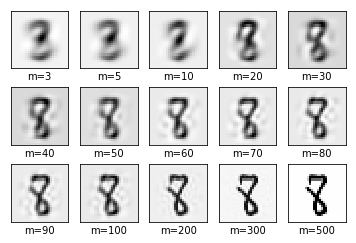

In [24]:
ms = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 500]
for i in range(1,16):
    ax = plt.subplot(3,5,i)
    transform_and_show(0, ms[i-1], ax)
    plt.xlabel(str('m=' + str(ms[i-1])))
    plt.xticks([])
    plt.yticks([])
plt.show()

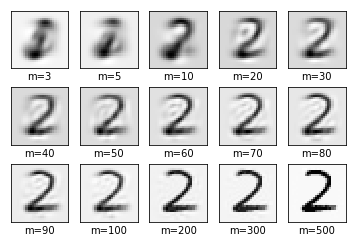

In [25]:
ms = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 500]
for i in range(1,16):
    ax = plt.subplot(3,5,i)
    transform_and_show(1, ms[i-1], ax)
    plt.xlabel(str('m=' + str(ms[i-1])))
    plt.xticks([])
    plt.yticks([])
plt.show()

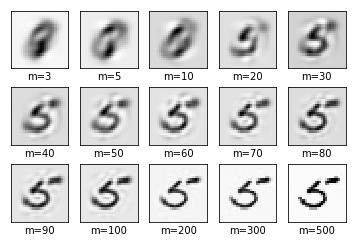

In [72]:
ms = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 500]
for i in range(1,16):
    ax = plt.subplot(3,5,i)
    transform_and_show(51, ms[i-1], ax)
    plt.xlabel(str('m=' + str(ms[i-1])))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [87]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## EM

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from scipy.sparse.linalg import svds, eigs
from sklearn.cluster import KMeans
from scipy.stats import mode
from matplotlib.pyplot import figure
import math
data=np.float64(np.load('MNIST.npy'))
labels=np.float32(np.load('MNIST_labels.npy'))
#converting into binary
data = (data!=0).astype(int)
#splitting into train, test, dev
ls = list(range(0, 70000))
train_mask = random.sample(ls, int(70000*0.6))
train_data = np.asarray(data[train_mask])
train_labels = np.asarray(labels[train_mask])
therest = list(set(ls)-set(train_mask))
test_mask = random.sample(therest, int(70000*0.2))
test_data = np.asarray(data[test_mask])
test_labels = np.asarray(labels[test_mask])
dev_mask = list(set(therest)-set(test_mask))
dev_data = np.asarray(data[dev_mask])
dev_labels = np.asarray(labels[dev_mask])

In [89]:
def initialize(X, M): #X is k x 784 matrix. each row is an image. k is the number of samples within one class
    n = len(X)
    init = np.asarray([np.random.randint(M) for i in range(n)])
    pi_vec = [sum(init==i)/n for i in range(M)]
    p_matrix = []
    for i in range(M):
        X_subset_t = np.matrix.transpose(X[init==i])
        p_matrix.append([(X_subset_t[i].sum()+1)/(len(X_subset_t[i])+2) for i in range(28**2)])
    return np.asarray(pi_vec), np.asarray(p_matrix)

In [90]:
def get_log_f_m(x, p_vec):
    log_p_vec = np.asarray([math.log(i) for i in p_vec])
    log_1minus_p_vec = np.asarray([math.log(1-i) for i in p_vec])
    vec_1minus_x = np.asarray([1-i for i in x])
    logfm = sum(x*log_p_vec + vec_1minus_x*log_1minus_p_vec)
    return logfm

In [91]:
def get_responsibility_x_m(x, m, pi_vec, p_matrix):
    M = len(pi_vec)
    lm_x = np.asarray([get_log_f_m(x, p_matrix[i]) + math.log(pi_vec[i]) for i in range(M)])
    L = max(lm_x)
    w_denom = sum(np.asarray([math.exp(lm-L) for lm in lm_x]))
    wmi = math.exp(lm_x[m] - L)/w_denom
    return wmi

In [92]:
def get_responsibilities(X, pi_vec, p_matrix):
    M = len(pi_vec)
    n = len(X)
    w_matrix = np.zeros((M, n))
    for m in range(M):
        for i in range(n):
            w_matrix[m][i] = get_responsibility_x_m(X[i], m, pi_vec, p_matrix)
    return w_matrix

In [93]:
def get_log_likelihood(X, pi_vec, p_matrix):
    n = len(X)
    M = len(pi_vec)
    outter_sum = 0
    for i in range(n):
        inner_sum = math.log(sum(np.asarray([math.exp(get_log_f_m(X[i], p_matrix[m])) for m in range(M)])))
        outter_sum+=inner_sum
    return outter_sum

In [94]:
def update_pi_vec(w_matrix):
    M = w_matrix.shape[0]
    n = w_matrix.shape[1]
    pi = np.asarray([(sum(w_matrix[m])+1)/(n+2) for m in range(M)])
    return pi

In [95]:
def runEM(X, M):
    pi,p = initialize(X, M)
    w = get_responsibilities(X, pi, p)
    l_old = get_log_likelihood(X, pi, p)
    loss_ratio = 2
    counter = 1
    while loss_ratio<0.9999:
        pi = update_pi_vec(w)
        p = update_p_matrix(w, X)
        w = get_responsibilities(X, pi, p)
        l_new = get_log_likelihood(X, pi, p)
        loss_ratio = l_new/l_old
        l_old = l_new
        print("iteration: ", counter, "loss: ", l_new, "ratio: ", loss_ratio)
        counter+=1
    return pi, p

In [96]:
%%time
X0 = train_data[train_labels==0]
pi0, p0 = runEM(X0, 3)
pi3 = pi0
p3 = p0
for i in range(1, 10):
    X0 = train_data[train_labels==i]
    pi0, p0 = runEM(X0, 3)
    pi3 = np.concatenate((pi3, pi0))
    p3 = np.concatenate((p3, p0))

Wall time: 17min 10s


In [97]:
%%time
w = get_responsibilities(test_data[0:1000], pi3, p3)

Wall time: 28min 26s


In [98]:
correct_label = [1 if (np.argmax(w[:,i])>=test_labels[i]*3 and np.argmax(w[:,i])<(test_labels[i]+1)*3)  else 0 for i in range(w.shape[1])] 

In [99]:
accuracy = sum(correct_label)/1000
print(accuracy)

0.833
